<a id='toc'></a>
# Table of Contents:
1. [Make Graph](#makegraph)
2. [Read in Yearly Prediction and Scale Back to Original Interval](#readscale)
3. [Exploratory Data Analysis](#eda) <br>
    3.1 [Data Wrangling](#wrangling) <br>
    3.2 [Calculating Per-Node Error](#node-error) <br>
    3.3 [Calculating Per-Pipe Error](#pipe-error) <br>
    3.4 [Leakage Labelset](#leaks) <br>
    3.5 [Dataset Pre-Processing](#pre-process) <br>
4. [Implementing CUSUM for Leakage Detection](#cusum)         <br>
    4.1 [Online CUSUM](#online)<br>
    4.2 [CUSUM Tuning (Preparation)](#tuning)<br>
    4.3 [CUSUM Tuning (Actual)](#actual)<br>
5. [Boem et al. Residual Analysis](#residual)

# Leak Detection

> Garðar Örn Garðarsson <br>
Integrated Machine Learning Systems 20-21 <br>
University College London

<a id='makegraph'></a>
*Back to [Table of Contents](#toc)*

## 1. Make Graph

Convert the `EPANET` model to a `networkx` graph

In [1]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
weight_mode     = 'pipe_length'
self_loops      = True
scaling         = 'minmax'
figsize         = (50,16)
print_out_rate  = 1               
model_name      = 'l-town-chebnet-' + weight_mode +'-' + scaling + '{}'.format('-self_loop' if self_loops else '')
last_model_path = './studies/models/' + model_name + '-1.pt'
last_log_path   = './studies/logs/'   + model_name + '-1.csv' 

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

<a id='readscale'></a>
*Back to [Table of Contents](#toc)*

## 2. Read in Yearly Prediction and Scale Back to Original Interval

In [2]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0')
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start=start_date,
                             periods=len(df),
                             freq = '5min')
    return df

In [3]:
n_timesteps = 3                                              # Timesteps, t-1, t-2...t-n used to predict pressure at t
sample_rate = 5                                              # Minutes sampling rate of data
offset      = pd.DateOffset(minutes=sample_rate*n_timesteps) # We require n_timesteps of data our first prediction

Load predictions

In [4]:
p18 = read_prediction(filename='2018_predictions.csv',
                      start_date=pd.Timestamp('2018-01-01 00:00:00') + offset)

Load reconstructions

In [5]:
r18 = read_prediction(filename='2018_reconstructions.csv',
                      start_date='2018-01-01 00:00:00')

Load leakage dataset

In [6]:
l18 = pd.read_csv('data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
l18.index = r18.index # Fix the index column timestamp format

<a id='eda'></a>
*Back to [Table of Contents](#toc)*

## 3. Exploratory Data Analysis

<a id='wrangling'></a>
*Back to [Table of Contents](#toc)*

### 3.1 Data Wrangling

Lets create a dictionary of the format:

`{ 'pipe_name' : [ connected_node_1 , connected_node_2 ] }`

For all the pipes in the network

In [7]:
neighbours_by_pipe = {}

for node in G:
    for neighbour, connecting_edge in G[node].items():
        if connecting_edge['name'] == 'SELF':
            continue
        else:
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]
            

Let's also create the inverse, when we want to look up pipes by their connecting nodes

In [8]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe , neighbour_list in neighbours_by_pipe.items()}

We'll also create a function to perform the lookup, as the order in which the nodes appear in the key matter and we don't bother with raising endless errors when looking up nodes we know to be connected, just cause we input them wrong

In [9]:
def pipeByneighbourLookup(node1, node2, pipe_by_neighbours, verbose=False):
    try:
        return pipe_by_neighbours[str([node1,node2])]    # If we don't find the first combination
    except:
        try:                                            # We try the next
            return pipe_by_neighbours[str([node2,node1])]
        except:                                         # And if we still don't find it
            if verbose:
                print('Nodes are not connected by a pipe')
            return None                                 # We return nothing

Try it out:

In [10]:
pipeByneighbourLookup(1,347,pipe_by_neighbours)

'p253'

In [11]:
pipeByneighbourLookup(347,1,pipe_by_neighbours)

'p253'

In [12]:
pipeByneighbourLookup(1,2,pipe_by_neighbours, verbose=True)

Nodes are not connected by a pipe


These might really come in handy when it comes to looking up pipe by node or for converting pipe leakage dataframes to leaky nodes!

<a id='node-error'></a>
*Back to [Table of Contents](#toc)*

### 3.2 Calculating Per-Node Error

We may calculate the node-wise validation error, $\epsilon_{n_{i}}$, by subtracting the predicted values with the reconstructed ones.

In [13]:
error_by_node = (p18-r18).copy()

<a id='pipe-error'></a>
*Back to [Table of Contents](#toc)*

### 3.3 Calculating Per-Pipe Error

We may calculate the pipe-wise validation errors, $\epsilon_{p_i}$, as the difference of the validation error of the two nodes connecting the pipe

In [14]:
error_by_pipe = {}

for key,value in neighbours_by_pipe.items():
    node_1 = 'n' + str(value[0])
    node_2 = 'n' + str(value[1])
    error_by_pipe[key] = ( error_by_node[node_1] - error_by_node[node_2] )
    
error_by_pipe = pd.DataFrame(error_by_pipe)

<a id='leaks'></a>
*Back to [Table of Contents](#toc)*

### 3.4 Leakage Labelset

Make a complete leakage labelset for each pipe

In [15]:
leaks_by_pipe = pd.DataFrame([], index=error_by_pipe.index, columns=error_by_pipe.columns)

for leaky_pipe in l18:
    leaks_by_pipe[leaky_pipe] = l18[leaky_pipe]
    
leaks_by_pipe = leaks_by_pipe.fillna(0.0)

Keep a dictionary of the timestamps of leakages

In [16]:
leak_timestamps = {}

for leak in l18:
    leak_timestamps[leak] = l18.index[l18[leak]>0]

In [17]:
leak_timestamps.keys()

dict_keys(['p31', 'p158', 'p183', 'p232', 'p257', 'p369', 'p427', 'p461', 'p538', 'p628', 'p654', 'p673', 'p810', 'p866'])

In [18]:
leak_timestamps['p673'][:3]

DatetimeIndex(['2018-03-05 15:45:00', '2018-03-05 15:50:00',
               '2018-03-05 15:55:00'],
              dtype='datetime64[ns]', freq='5T')

In [19]:
timestamp = leak_timestamps['p673'][:4] - pd.Timedelta(minutes=10) # Check moments before leak
leaks_by_pipe['p673'][timestamp]

2018-03-05 15:35:00     0.0
2018-03-05 15:40:00     0.0
2018-03-05 15:45:00    28.4
2018-03-05 15:50:00    28.4
Freq: 5T, Name: p673, dtype: float64

Alternatively, make a node-wise leak labelset!

In [20]:
leaks_by_node = pd.DataFrame(data=np.zeros(error_by_node.shape), 
                             index = error_by_node.index, 
                             columns = np.arange(1,783))

In [21]:
for pipe,neighbours in neighbours_by_pipe.items():
    for neighbour in neighbours:
        leaks_by_node[neighbour] += leaks_by_pipe[pipe]

In [22]:
leaks_by_node[42][leak_timestamps[pipeByneighbourLookup(40,42,pipe_by_neighbours)]]

2018-06-29 01:35:00     0.01
2018-06-29 01:40:00     0.01
2018-06-29 01:45:00     0.01
2018-06-29 01:50:00     0.01
2018-06-29 01:55:00     0.01
                       ...  
2018-08-12 17:10:00    16.01
2018-08-12 17:15:00    16.01
2018-08-12 17:20:00    16.00
2018-08-12 17:25:00    15.99
2018-08-12 17:30:00    16.00
Freq: 5T, Name: 42, Length: 12864, dtype: float64

In [23]:
leaks_by_node.head()

,1,2,3,4,5,6,7,8,9,10,...,773,774,775,776,777,778,779,780,781,782
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='pre-process'></a>
*Back to [Table of Contents](#toc)*

### 3.5 Dataset Pre-Processing

Process the dataset for timeseries classification. <br>
I want to devise a set where I have a configurable window of observations, `[1, 5, 10, ... 200]`.<br>
For that window of observations, I sum the per pipe events such that the according label will read `[0, 0, 1, 0, ...]`, where the set bit indicates the leaky pipes for that interval. <br>

First clean out the `NaNs` from the feature and labelset caused by the window size of the predictive model

In [24]:
error_by_pipe = error_by_pipe.dropna()

In [25]:
leaks_by_pipe = leaks_by_pipe[leaks_by_pipe.index.isin(error_by_pipe.index)]

Similarly for the pipe-wise classification, do it for the node-wise classification

In [26]:
error_by_node = error_by_node.dropna()

In [27]:
leaks_by_node = leaks_by_node[leaks_by_node.index.isin(error_by_node.index)]

Split up the feature and labelset for classification

In [28]:
def classificationTaskSplitter(x,y,window_size=10,data_slice=None):
    
    if not data_slice:
        data_slice = len(x)
        
    window_start = 0
    window_end   = window_start+window_size

    features = []
    labels   = []

    for i in range(len(x[window_start:data_slice])):
        features.append( x.iloc[window_start:window_end].to_numpy() )
        labels.append(  (y.iloc[window_start:window_end].sum().to_numpy() > 5).astype(int) )
        window_start += 1
        window_end   += 1
    
    return np.array(features), np.array(labels)

In [29]:
x, y = classificationTaskSplitter(error_by_node, error_by_node, window_size=24, data_slice = 100)

In [30]:
print("x: {} \ny: {}".format(x.shape, y.shape))

x: (100, 24, 782) 
y: (100, 782)


In [31]:
x[0].shape

(24, 782)

In [32]:
x[0].reshape(782*24).shape

(18768,)

<a id='cusum'></a>
*Back to [Table of Contents](#toc)*

## 4. Implementing CUSUM for Leakage Detection

Use Marcos Duarte's implementation of the CUSUM algorithm: 

https://github.com/BMClab/BMC/blob/master/functions/detect_cusum.py<br>
https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [33]:
from utils.cusum import detect_cusum
import networkx as nx

/Users/gardar/Documents/UCL/ELEC0054 IMLS Research Project/04 Implementation/04 Leakage Detection/utils/cusum.py:11: UserWarning: A newest version is available at https://pypi.org/project/detecta/
  warnings.warn('A newest version is available at https://pypi.org/project/detecta/')


Let's not standardise the signals for now:

<AxesSubplot:>

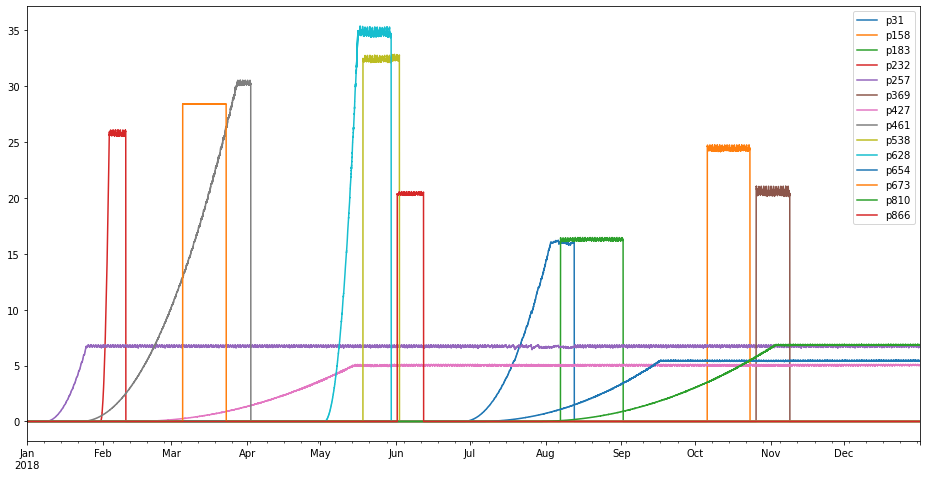

In [34]:
l18.plot(figsize=(16,8))

In [35]:
error_by_node['n42'].describe()

count    105117.000000
mean          0.007183
std           0.002786
min          -0.002804
25%           0.005068
50%           0.006779
75%           0.009170
max           0.020658
Name: n42, dtype: float64

Let's try out the function:

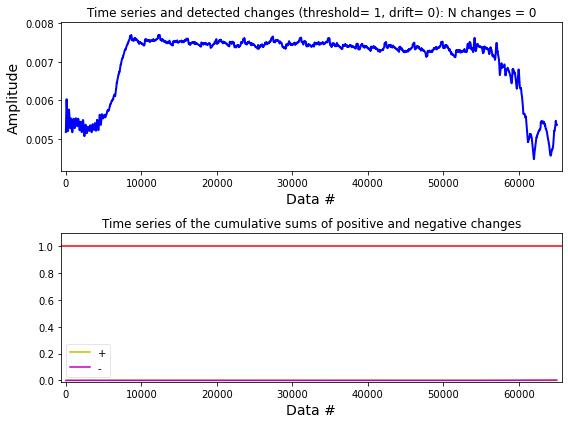

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [36]:
detect_cusum(error_by_node['n42'].rolling('7d',min_periods=288).mean().dropna()[:65000], 
             threshold = 1, 
             drift     = 0, 
             show      = True, 
             ending    = True)

<a id='online'></a>
*Back to [Table of Contents](#toc)*

### 4.1 Online CUSUM

I wonder what the detections look like if we are processing the signal on-line

Define a function to calculate the moving average of a `np.array`

In [37]:
def movingAverage(x, window=10):
    return np.convolve(x, np.ones(window), 'valid') / window

Define a function that returns the number of intervals that should be used for a given timeframe and sampling rate

In [38]:
def determineWindowSize(window='5d',sampling_rate='5min'):
    return int(pd.Timedelta(window) / pd.Timedelta(sampling_rate))

Let's try out our moving average function

In [39]:
signal = []
window = determineWindowSize(window='7d',sampling_rate='5min')

for measurement in error_by_node['n42'][45000:65000]:
    signal.append(measurement)

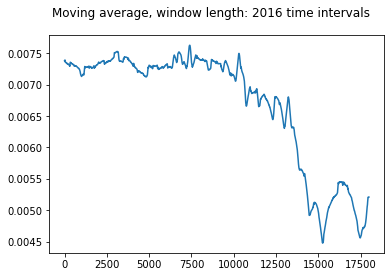

In [40]:
# Get the size of a 7-day window for a signal with 5-min sampling rate
window = determineWindowSize(window='7d',sampling_rate='5min') 
# Plot the moving average of the signal 
plt.plot(movingAverage(signal,window))                          
plt.suptitle('Moving average, window length: {} time intervals'.format(window))
plt.show()

Emulate that this were happening online:<br>
**This takes a bunch of time to execute so leaving it commented out, the `np.append` is very compute intensive, regular python append is better**

I can confirm that computing the `movingAverage` on-line, and applying the $\text{CUSUM}$ algorithm with the `detect_cusum` function yields the same result sequentially, as if we pass the function the same complete frame. <br>
In the case of node `n42`, for the dataslice `45000:65000` it always returns `15113` as the time of alarm, and hasn't alarmed prematurely before encountering the value at timestep `15113` when processing sequentially. 

See below:

In [ ]:
signal = []
m_avg  = []
window = determineWindowSize(window='7d',sampling_rate='5min')

for measurement in error_by_node['n42'][45000:65000]:
    signal.append(measurement)
    m_avg.append(movingAverage(np.array(signal),window))

Now we have a moving average signal for all the timesteps in `[45000:65000]`.<br>
So, let's try and run $\text{CUSUM}$ on the entire moving average signal:

In [ ]:
ta, _, _, _ = detect_cusum(movingAverage(signal,window), 
                           threshold =0.008, 
                           drift = 1e-7, 
                           show = True,
                           ending = False)
print("Time of alarm at: {}".format(ta))

OK ✅ <br>
But now, if we were to calculate the same moving average signal up until the time of alarm?

In [ ]:
ta, _, _, _ = detect_cusum(movingAverage(signal[:15113],window), 
                           threshold =0.008, 
                           drift = 1e-7, 
                           show = True,
                           ending = False)
print("Time of alarm at: {}".format(ta))

Hmm, no and from the $g_+$ and $g_-$ plots (the one at the bottom in the figure above) it seems the sums are far from reaching the threshold

I wonder if this is due to our smoothing of the signal, i.e. is the rolling mean window causing this "delay"?

In [ ]:
ta, _, _, _ = detect_cusum(m_avg[15113+window], 
                           threshold =0.008, 
                           drift = 1e-7, 
                           show = True,
                           ending = False)
print("Time of alarm at: {}".format(ta))

Well, yes so it seems, what if we look at the time interval just before ?

In [ ]:
ta, _, _, _ = detect_cusum(m_avg[15113+window-2], 
                           threshold =0.008, 
                           drift = 1e-7, 
                           show = True,
                           ending = False)
print("Time of alarm at: {}".format(ta))

Bingo... no alarm, so effectively we've sliced the front of the data while gathering the averages:

In [ ]:
movingAverage(signal[:15113],window).shape

That's why the indices didn't match up, d'oy

<a id='tuning'></a>
*Back to [Table of Contents](#toc)*

### 4.2 CUSUM Tuning (Preparation)

Let's now start focusing on tuning the $\text{CUSUM}$ algorithm.

I was thinking if we should tune it such that:

1. We use a part or majority of the historical leakage dataset of 2018 to tune.
2. We count the number of events that should be detected in every pipe residual signal in the network, from the historical data.
3. To refrain from overfitting with this approach, for a single pipe leakage, we count it as one event to be detected in the leaky pipe, and it‘s $k$-th order neighbours <br>
    3.1 Pipes that are not  $k$-th order neighbours of pipes with leakages in 2018 will thus have this set to 0 <br>
    3.2 Pipes that have leaked in 2018 and/or are the $k$-th order neighbour‘s of a leaky pipe, can thus have this set to $1, 2, ... , n$ number of leaks in k-neighbourhood.
4. We run CUSUM on a given residual signal, and from the permittable number of events to be detected in the given signal, we can compare it with the number of detections to obtain missed detections and false alarms.
5. Adjust threshold and drift accordingly and repeat until convergence
6. Repeat for all pipes
 
For tuning the sensitivity, I think rather than starting from a large threshold and stepping down (top-down approach), it would be more feasible to start from a small threshold and aim to minimising false detections (bottom-up approach).
I get the feeling if we start with a large threshold, we will leave it at a large threshold in the pipes with no leaks, so in future detections we may miss events due to this.

Let's start out by figuring out which nodes we allow $\text{CUSUM}$ to detect events in, such that we don't lose the isolation capabilities of a leakage event

In [ ]:
l18.head()

And we have a method for getting the two connecting nodes:

In [ ]:
neighbours_by_pipe['p31']

So we can return all the nodes in the neighbourhood of the leaky pipe 

In [ ]:
nx.single_source_shortest_path_length(G, 40, cutoff=3)

And to get the unique set of nodes for both edges connected by the pipe, I take the peculiar approach of making a `DataFrame` from the dicts and snatching the header 😅

In [ ]:
node_1_neighbours = nx.single_source_shortest_path_length(G, 42, cutoff=3)
node_2_neighbours = nx.single_source_shortest_path_length(G, 40, cutoff=3)

n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]

In [ ]:
n_hop_neighbours

Okay, so from this we could calculate for all the nodes in the network, how many permittable events are to be detected in them <br>
Let's put this all together

In [ ]:
node_total_leak_events = {key: 0 for key in np.arange(1,783)}

for leaky_pipe in l18:
    # Get the nodes connected by the leaky pipe
    leaky_nodes       = neighbours_by_pipe[leaky_pipe]
    
    # Return the k-hop neighbours of those nodes
    node_1_neighbours = nx.single_source_shortest_path_length(G, leaky_nodes[0], cutoff=2)
    node_2_neighbours = nx.single_source_shortest_path_length(G, leaky_nodes[1], cutoff=2)
    
    # As they can share neighbours, we need to get the unique neighbours
    n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]
    
    for node in n_hop_neighbours:
        node_total_leak_events[node] += 1

But how many unique pipes could then be detected given the 3-hop neighbourhood rule?

In [ ]:
permissible_detections = 0
for k,v in node_total_leak_events.items():
    if v > 0:
        permissible_detections += 1
permissible_detections

And how many detections could that mean in the year?

In [ ]:
permissible_detections = 0
for k,v in node_total_leak_events.items():
    if v > 0:
        permissible_detections += v
permissible_detections

Hmm, maybe we need to be tighter on the $k$-hop neighbourhood!<br>
**Let's revise the neighbourhood when it comes to tuning the $\mathbf{CUSUM}$ thresholds**

So, okay, we ofcourse have to point to a leaky pipe, not a leaky node, that is our end goal. <br>
Thus, we must now devise a method, such that if a leakage is detected in a node, or better, a couple of nodes, it returns a single leaky pipe, that is shared by the original leaky node, within a given k-hop neighbourhood.

Some leaky pipes:

In [ ]:
l18.columns[:5]

The two connecting nodes of a leaky pipe

In [ ]:
leaky_nodes = neighbours_by_pipe['p158']
leaky_nodes

The unique neighbours of the two nodes:

In [ ]:
# Return the k-hop neighbours of those nodes
node_1_neighbours = nx.single_source_shortest_path_length(G, leaky_nodes[0], cutoff=3)
node_2_neighbours = nx.single_source_shortest_path_length(G, leaky_nodes[1], cutoff=3)

# As they can share neighbours, we need to get the unique neighbours
n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]
print("First five, unique node neighbours of the leaky pipe: {}...".format(n_hop_neighbours[:5]))

We can devise a method to return all the pipes in a $k-$hop neighbourhood

In [ ]:
pipes_in_neighbourhood = []                                                    # List of neighbourhood pipes
for neighbour1 in n_hop_neighbours:                                            # For neighbour 1 
    for neighbour2 in n_hop_neighbours:                                        # For neighbour 2
        pipe = pipeByneighbourLookup(neighbour1,neighbour2,pipe_by_neighbours) # Look for a connecting pipe ...
        if pipe:                                                               # ... with the neighbours and if found:
            pipes_in_neighbourhood.append(pipe)                                # .... add it to the list

In [ ]:
pipes_in_neighbourhood[:6]

Wrap this all to a single function:

In [ ]:
def discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, graph, k=3):
    
    leaky_nodes = neighbours_by_pipe[pipe]
    
    node_1_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[0], cutoff=k)
    node_2_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[1], cutoff=k)
    
    n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]

    pipes_in_neighbourhood = []                                                    # List of neighbourhood pipes
    for neighbour1 in n_hop_neighbours:                                            # For neighbour 1 
        for neighbour2 in n_hop_neighbours:                                        # For neighbour 2
            pipe = pipeByneighbourLookup(neighbour1,neighbour2,pipe_by_neighbours) # Look for a connecting pipe ...
            if pipe:                                                               # ... with the neighbours and if found:
                pipes_in_neighbourhood.append(pipe)                                # .... add it to the list
    
    return pipes_in_neighbourhood, n_hop_neighbours

In [ ]:
discoverNeighbourhood(pipe='p158', 
                      neighbours_by_pipe=neighbours_by_pipe, 
                      pipe_by_neighbours=pipe_by_neighbours,
                      graph=G,
                      k=1)

Okay let's now connect this together, we need to try to tune $\text{CUSUM}$ for a couple of leaky and non leaky pipes.

In [ ]:
pipes,nodes = discoverNeighbourhood(pipe='p158', 
                                    neighbours_by_pipe=neighbours_by_pipe, 
                                    pipe_by_neighbours=pipe_by_neighbours,
                                    graph=G,
                                    k=1)

In [ ]:
nodes

In [ ]:
pipes[:4]

<a id='actual'></a>
*Back to [Table of Contents](#toc)*

### 4.3 CUSUM Tuning Actual
For the CUSUM algorithm to work properly, it depends on tuning the parameters h and v to what is meant by a change in the data. According to Gustafsson (2000), this tuning can be performed following these steps:

*         Start with a very large threshold. 
*         Choose drift to one half of the expected change, or adjust drift such that g = 0 more than 50% of the time.
*         Then set the threshold so the required number of false alarms (this can be done automatically) or delay for detection is obtained.
*         If faster detection is sought, try to decrease drift.
*         If fewer false alarms are wanted, try to increase drift.
*         If there is a subset of the change times that does not make sense, try to increase drift.

In [ ]:
window      = '7d'
min_periods = determineWindowSize('12h',sampling_rate='5min')

ta, tai, taf, amp = detect_cusum(error_by_node['n42'].rolling(window, min_periods).mean().dropna(), 
                                 threshold = 0.01, 
                                 drift     = 1e-7, 
                                 show      = True) 

In [ ]:
if 122 not in nodes:
    nodes.append(122) 
    
thresholds = {k:1e-3 for k in nodes}
drifts     = {k:0 for k in nodes}
window     = '7d'
tas        = []

for i,node in enumerate(nodes):
    node_str = 'n'+str(node)
    tas.append(detect_cusum(error_by_node[node_str].rolling(window, min_periods).mean(), 
                                     threshold = thresholds[node], 
                                     drift     = drifts[node], 
                                     show      = False)[0])

<a id='residual'></a>
*Back to [Table of Contents](#toc)*

## 5. Boem et al. Residual Analysis

Configure parameters:

\begin{equation}
m = \frac{ 7~\text{days} }{ 5~\text{minutes} } = 2016
\end{equation}

\begin{equation}
\alpha = 1 
\end{equation}

In [ ]:
window  = '7d'
wdw_int = determineWindowSize(window,sampling_rate='5min')
min_per = determineWindowSize('7d' ,sampling_rate='5min')
alpha   = 1

print("m:\t{}\nalpha:\t{}".format(wdw_int,alpha))

Standardise the signals to be analysed, by subtracting the mean and dividing by the std.dev:

\begin{equation}
S(k) = \frac{\epsilon_i - \mu_{\epsilon_i} } { \sigma_{\epsilon_i}}
\end{equation}

❗️**The signal should only be standardised from data under healthy condition** ❗️

So we've already found the timestamps of all the leakages:

In [ ]:
for pipe,time in leak_timestamps.items():
    print("Pipe:\t{}\tStart:\t{}\tEnd:\t{}".format(pipe, time[0], time[-1]))

And we have a method for returning the $k$ neighbourhood of a pipe of interest

In [ ]:
pipes, nodes = discoverNeighbourhood('p31', neighbours_by_pipe, pipe_by_neighbours, G, k=3)
nodes

So we could use this to retrieve a list of date-time indices that denote faulty condition, for neighbouring nodes of leakages, that we then leave-out from the standardisation of the signal.

In [ ]:
fault_times = {}

# First populate the key variable with empty lists, that are the k-hop neighbouring nodes of leaky pipes:
for pipe in leak_timestamps.keys():
    _, nodes = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)
    for node in nodes:
        fault_times[node] = []

So there are in fact:

In [ ]:
len(fault_times.keys())

nodes that we will consider affected by near-by leakage events given $k=3$

Now that we've initialised the dictionary with empty lists, we can again iterate through the `leak_timestamps` and append them to the lists, thereby, taking care of not overwriting recurring nodes:

*Note: recurring nodes, would be nodes that are in the $k$ neighbourhood of more than one leakages*

In [ ]:
for pipe, time in leak_timestamps.items():
    _, nodes = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)
    for node in nodes:
        fault_times[node].append(time)

In [ ]:
healthy = error_by_node['n199'][~error_by_node['n199'].index.isin(fault_times[199][0]) & \
                                ~error_by_node['n199'].index.isin(fault_times[199][1]) ].mean()

Okay so, calculate the averages and standard deviations to be subtracted in case of faulty nodes:

In [ ]:
faulty_avg = {}
faulty_std = {}

for node, dt_list in fault_times.items():
    
    n_faulty_periods = len(dt_list)
    node_name        = 'n' + str(node)

    if n_faulty_periods == 1:
        faulty_avg[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0])].mean()
        faulty_std[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0])].std()
        
    if n_faulty_periods == 2:
        faulty_avg[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][1]) ].mean()
        faulty_std[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][1]) ].std()
    if n_faulty_periods == 3:
        faulty_avg[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][1]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][2]) ].mean()
        faulty_std[node_name] = error_by_node[node_name][~error_by_node[node_name].index.isin(fault_times[node][0]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][1]) & \
                                                         ~error_by_node[node_name].index.isin(fault_times[node][2]) ].std()
        

And standardise the residual signals given these averages and std.devs:

In [ ]:
signal = pd.DataFrame([])
for node in error_by_node:
    if node in faulty_avg.keys():
        signal[node] = (error_by_node[node] - faulty_avg[node]) / faulty_std[node]
    else:
        signal[node] = (error_by_node[node] - error_by_node[node].mean()) / error_by_node[node].std()

The signal to be assessed is then the absolute value of the rolling mean of the standardised 
residual signal

\begin{equation}
|\bar{r}^{(m)}(k)| = \text{ABS} \left( \frac{1}{m} \sum_{i=0}^{m} S(k-i) \right)
\end{equation}

In [ ]:
r_m_k = abs(signal.rolling(window,min_per).mean().dropna())

Now, for the threshold, we define it as: 

\begin{equation}
\bar{\rho}^{(m)}(k) = \alpha \bar{\sigma}^{(m)}(k)
\end{equation}

Where:

\begin{equation}
(\bar{\sigma}^{(m),B}(k))^2 = \frac{1}{m} \sum_{j=0}^{m-1} (\sigma^B(k-j))^2
\end{equation}

... or effectively, the threshold is some value $\alpha$ times the rolling standard deviation of the signal


In [ ]:
threshold = {}

for node in error_by_node:
    threshold[node] = alpha * signal[node].rolling(window,min_per).std().dropna() # ALPHA !!!

threshold = pd.DataFrame(threshold)

In [ ]:
faults = (r_m_k >= threshold).astype('int')

Analyse a single event, these pipes had leaks:

In [ ]:
l18.columns

Let's pick out a single pipe failure and inspect the signal and detection in the neighbourhood

In [ ]:
discoverNeighbourhood(pipe='p31', 
                      neighbours_by_pipe=neighbours_by_pipe, 
                      pipe_by_neighbours=pipe_by_neighbours,
                      graph=G,
                      k=1)

In [ ]:
plt.figure(figsize=(16,6))

node = 'n' + str( 40 )
pipe = 'p31'

# zoomed = leak_timestamps['p31']+pd.Timedelta(days=7)

threshold[node].plot( label = r'Threshold $(\bar{\sigma}^{(m),B}(k)^2$)')
r_m_k[    node].plot( label = r'Residual m.avg $|\bar{r}^{(m)}(k)|$')
(faults[  node]).plot(label =  'Classified faults r>p')
(0.1*l18[ pipe]).plot(label =  'Actual leakage in {}'.format(pipe))
plt.legend()
plt.title('Node: {}\nPipe leak @: {}'.format(node, pipe))
plt.show()

Let's automate saving the residual signal analysis results of all leaky pipes and their 1-hop neighbours:

Faults found in how many pipes (?)

In [82]:
len(faults.columns) - ((faults.sum()<=0).astype('int')).sum()
#  ^ total n pipes      ^ Mask out pipes with 0 faults   ^ and count them

478

Times of fault?

In [83]:
fault_times = {}

for node in faults:
    fault_times[node] = faults.index[faults[node]>0]


Ok, so how do I get from this format: 

`faults`:

| TimeStamp          |     n1      |   n2    |...|n782|
| ------------------ | ----------- |---------|---|----|
| 2018-01-01 00:00:00|     0       |    1    |...|  0 |
| 2018-01-01 00:05:00|     1       |    0    |...|  0 |

To this:

 `results.txt`:

```
p357, 2018-01-01 00:00:00
p29,  2018-03-04 17:35:00
...
```

My idea is the following algorithm:

```

leaks = {}

for timestep in faults:
    for node in faults:
        if node has fault:
            # Look up the k-neighbourhood nodes to the faulty one
            neighbours = lookUpNeighbours(node, k=3)
        
            for neighbour in neighbours:
                if neighbour has fault:
                    # Find the shortest path between the k-neighbouring nodes
                    connecting_edges = shortestPath(node, neighbour)
                    
                    # Classify the edge closest to the original faulty node as the leaky one
                    leaky_pipe       = connecting_edges[0]
                    
                    #                        .
                    #                        .
                    #                        .
                    # Run some test to see if we've already classified a leakage in 
                    # the k-neighbourhood of this pipe (?)
                    # How do we go about doing this only for active events not
                    # some ancient ones?
                    # FIFO buffer of 'n' events?
                    #                        .
                    #                        .
                    #                        .
                    
                    time_of_event    = timestep
                    entry            = leaky_pipe + ', ' + time_of_event
```

**Okay!** <br>
Devise a function to return the pipes that connect two pipes:

In [84]:
def getShortestPath(graph, source, dest, attribute='name'):
    
    path          = nx.shortest_path(G)
    edge_labels   = nx.get_edge_attributes(G, attribute)
    path_by_edges = [edge_labels.get(x, edge_labels.get((x[1],x[0]))) \
                     for x in zip(path[source][dest], path[source][dest][1:])]
    path_by_nodes = path[source][dest]

    return path_by_edges, path_by_nodes

Measure performance

In [85]:
import time

In [86]:
startTime = time.time()
pipes, nodes = getShortestPath(G, 40, 389)
print(time.time()-startTime)
print(pipes[0])

1.044644832611084
p31


Hmm, not good seeing the complexity of the computation, let's try a more minimal approach:

In [87]:
def firstPipeInPath(graph, source, dest, attribute='name'):
    # Get shortest path was WAY too slow, (0.7 sec) so created minimal version that returns first pipe in path
    path          = nx.shortest_path(G, source, dest)
    edge_labels   = nx.get_edge_attributes(G, attribute)
    try: 
        return edge_labels[(path[0], path[1])]
    except:
        return edge_labels[(path[1], path[0])]

⏱⏱⏱ **Measure performance** ⏱⏱⏱ 

In [88]:
startTime = time.time()
pipe = firstPipeInPath(G, 40, 389)
print(time.time()-startTime)
print(pipe)

0.0008208751678466797
p31


🏃‍♀️  Thaaaaaat's gonna make some difference 😅🙈

Make an indexable dictionary of the 3-hop neighbours, so as not to generate it every iteration

In [89]:
_3_hop_neighbours = {}

for node in np.arange(1,783):
    _3_hop_neighbours[node] = sorted(list(nx.single_source_shortest_path_length(G, node, cutoff=3).keys()))
    _3_hop_neighbours[node].remove(node)

Re-address the column names of the faults dataframe to numeric node names, rather than `n1, n2, n3 ... ` strings

In [90]:
faults.columns=np.arange(1,783)

In [126]:
faults[5000:]

,1,2,3,4,5,6,7,8,9,10,...,773,774,775,776,777,778,779,780,781,782
2018-01-25 08:50:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-25 08:55:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-25 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-25 09:05:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-25 09:10:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:40:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:50:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
startTime=time.time()
leaks = {}

for timestep in faults.index[5000:5100]:
    for node in faults:
        if faults[node][timestep]:
            for nbor in _3_hop_neighbours[node]:
                if faults[nbor][timestep]:
                    pipe     = firstPipeInPath(G, node, nbor)
                    pipes,_  = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)
                    check    = any(pipe in pipes for pipe in list(leaks.keys()))
                    if check:
                        break
                    else:
                        leaks[pipe]=timestep
                        
print(time.time()-startTime)

In [ ]:
leaks

In [203]:
np_faults = faults[5000:5100].to_numpy()

In [204]:
np_faults.shape

(100, 782)

In [215]:
startTime=time.time()
leaks = {}

for timestep in range(np_faults.shape[0]):
    for node in range(np_faults.shape[1]):
        if np_faults[timestep][node]:
            for nbor in _3_hop_neighbours[node]:
                if np_faults[timestep][node]:
                    pipe     = firstPipeInPath(G, node, nbor)
                    pipes,_  = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)
                    check    = any(pipe in pipes for pipe in list(leaks.keys()))
                    if check:
                        break
                    else:
                        leaks[pipe]=timestep
                        
print(time.time()-startTime)

14.848704099655151


In [140]:
faults.index[5000:5010]

DatetimeIndex(['2018-01-25 08:50:00', '2018-01-25 08:55:00',
               '2018-01-25 09:00:00', '2018-01-25 09:05:00',
               '2018-01-25 09:10:00', '2018-01-25 09:15:00',
               '2018-01-25 09:20:00', '2018-01-25 09:25:00',
               '2018-01-25 09:30:00', '2018-01-25 09:35:00'],
              dtype='datetime64[ns]', freq='5T')

In [143]:
faults.index[10]

Timestamp('2018-01-08 01:00:00', freq='5T')

In [177]:
i          = 0
start_time = faults.index[i]
end_time   = faults.index[100]

In [190]:
startTime = time.time()
while (start_time != end_time):
    i+=1
    start_time = faults.index[i]
print(time.time()-startTime)

0.0001227855682373047


In [193]:
startTime = time.time()
for timestamp in faults.index[:100]:
    timestamp
print(time.time()-startTime)

0.0004909038543701172


.... mmmm with this performance, it would still take a whole:

In [130]:
13/100*105120/60/60

3.7960000000000003

**HOURS to generate the 🤬🤬🤬 results**

Multi-processing:

In [103]:
import multiprocessing as mp

In [104]:
manager = mp.Manager()
LEAKS   = manager.dict()

In [105]:
def leakCandidateSelection(LEAKS, faults, graph, _3_hop_neighbours, neighbours_by_pipe, pipe_by_neighbours, k=3):
    #leaks = {}

    for timestep in faults.index[:10]:
        for node in faults:
            if faults[node][timestep]:
                for nbor in _3_hop_neighbours[node]:
                    if faults[nbor][timestep]:
                        pipe     = firstPipeInPath(G, node, nbor)
                        pipes,_  = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
                        check    = any(pipe in pipes for pipe in list(LEAKS.keys()))
                        if check:
                            break
                        else:
                            LEAKS[pipe]=timestep

In [110]:
startTime=time.time()
p1 = mp.Process(target=leakCandidateSelection, 
               args=(LEAKS, faults, G, _3_hop_neighbours, neighbours_by_pipe, pipe_by_neighbours,3))
p2 = mp.Process(target=leakCandidateSelection, 
               args=(LEAKS, faults, G, _3_hop_neighbours, neighbours_by_pipe, pipe_by_neighbours,3))
p3 = mp.Process(target=leakCandidateSelection, 
               args=(LEAKS, faults, G, _3_hop_neighbours, neighbours_by_pipe, pipe_by_neighbours,3))

p1.start()
p2.start()
p3.start()
p1.join()
p2.join()
p3.join()
print(time.time()-startTime)

6.540585994720459


In [101]:
LEAKS.copy()

{'p241': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p245': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p280': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p34': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p35': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p36': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p37': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p385': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p416': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p95': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p98': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p110': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p359': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p90': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p476': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p113': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p114': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p522': Timestamp('2018-01-08 00:10:00', freq='5T'),
 'p529': Timestamp('2018-01-08 00:1

In [102]:
len(LEAKS.copy())

56

In [570]:
%%timeit
pipe     = firstPipeInPath(G, node, nbor)
pipes,_  = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)
check    = any(pipes for keys in leaks)

2.21 ms ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [571]:
%%timeit
pipe     = firstPipeInPath(G, node, nbor)
check    = any(discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)[0] for keys in leaks)

2.28 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [572]:
%%timeit
pipe     = firstPipeInPath(G, node, nbor)
check    = any(discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)[0] for keys in leaks)
if check in leaks:
    pass

2.31 ms ± 90.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [573]:
%%timeit
pipe     = firstPipeInPath(G, node, nbor)
if any(discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=3)[0] for keys in leaks) in leaks:
    pass

2.29 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Adaptive threshold for CUSUM

Trying out the simulation described in: [Adaptive threshold computation for CUSUM-type procedures in change detection and isolation problems](https://www.sciencedirect.com/science/article/pii/S0167947308000212)

In [556]:
def gaussianWhiteNoise(mean=0, variance=2e-4, n_samples=1000):
    std = np.sqrt(variance)
    num_samples = 1000
    return np.random.normal(mean, std, size=num_samples)

In [557]:
def faultMode(healthy_val=0.5, faulty_val=0.4, probability_of_fault=0.001):
    return healthy_val if np.random.uniform(0,1) > probability_of_fault else faulty_val

In [295]:
epsilon = gaussianWhiteNoise(mean=0, variance=2e-4, n_samples=1000)

In [296]:
theta     = np.array([faultMode(0.5,0.4,0.002) for i in range(1000)])

In [298]:
X_t = np.zeros(1000)

In [299]:
time = np.arange(0,1000,1)

In [300]:
for t in time:
    X_t[t] = theta[t] * X_t[t-1] * np.cos(0.02*t) + 0.5 + epsilon[t]

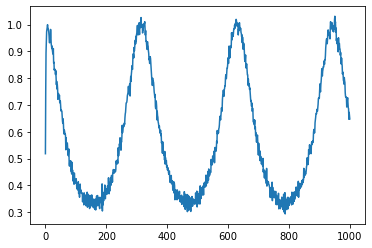

In [301]:
plt.plot(X_t)

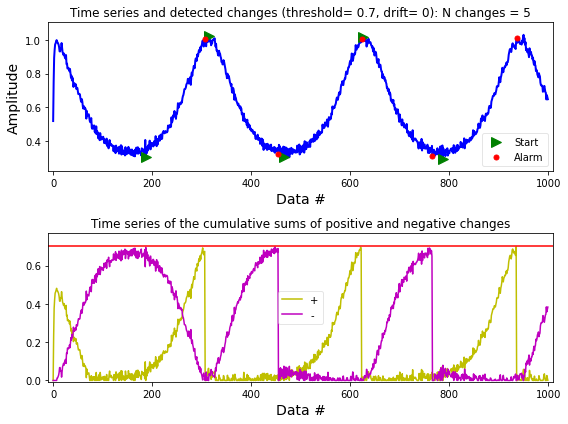

In [309]:
ta, tai, taf, amp = detect_cusum(X_t, 
                                 threshold = 0.70, 
                                 drift     = 0, 
                                 show      = True) 